In [87]:

# What is your house worth? What is your neighbor's house worth? We can screen scrape houses from Zillow and compare all the prices of all the 
# homes, based on 'Price', 'Beds', 'Baths', and 'Square Footage', to determine which are relatively more expensive when compared to their 
# peers and likewise, we can determine which are relatively less expensive when compared to their peers. By doing this, we can find the relative
# value of all houses compared to all other houses.


In [19]:

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

# Start a new Chrome session
driver = webdriver.Chrome()

driver.get('https://www.zillow.com/breckenridge-co/')  # Update this URL

all_homes = []

while True:
    # Scroll down to load more data
    SCROLL_PAUSE_TIME = 2
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    # Parse the page content
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Extract data
    property_cards = soup.find_all('div', class_='StyledPropertyCardDataWrapper-c11n-8-102-0__sc-hfbvv9-0')
    for card in property_cards:
        try:
            # Price
            price = card.find('span', {'data-test': 'property-card-price'}).text.strip()
            
            # Address
            address_tag = card.find('a', {'data-test': 'property-card-link'})
            address = address_tag.find('address', {'data-test': 'property-card-addr'}).text.strip()
            
            # Details (beds, baths, sqft)
            details = card.find('div', class_='StyledPropertyCardDataArea-c11n-8-102-0__sc-10i1r6-0 gAnZoM').ul.find_all('li')
            beds = details[0].text.strip()
            baths = details[1].text.strip() if len(details) > 1 else 'N/A'
            sqft = details[2].text.strip() if len(details) > 2 else 'N/A'

            all_homes.append([address, price, beds, baths, sqft])
        except AttributeError:
            continue
    
    # Try to go to the next page
    try:
        next_button = driver.find_element(By.XPATH, "//a[@title='Next page']")
        driver.execute_script("arguments[0].click();", next_button)
        time.sleep(2)
    except NoSuchElementException:
        print("No more pages to scrape.")
        break
    except ElementClickInterceptedException:
        print("Next button not clickable. Trying again.")
        time.sleep(2)

driver.quit()

# Create DataFrame
df = pd.DataFrame(all_homes, columns=['Address', 'Price', 'Beds', 'Baths', 'Square Footage'])

# Convert data types
df['Price'] = df['Price'].str.replace('[\$,]', '', regex=True).astype(float)
df['Beds'] = df['Beds'].str.extract('(\d+)').astype(float)
df['Baths'] = df['Baths'].str.extract('(\d+)').astype(float)
df['Square Footage'] = df['Square Footage'].str.replace(',', '').str.extract('(\d+)').astype(float)

display(df.head())


No more pages to scrape.


,Address,Price,Beds,Baths,Square Footage
0,"208 N Ridge St, Breckenridge, CO 80424",4275000.0,3.0,4.0,2222.0
1,"34 Highfield Trl #100, Breckenridge, CO 80424",850000.0,2.0,2.0,713.0
2,"1781 Tiger Rd, Breckenridge, CO 80424",3795000.0,5.0,5.0,3621.0
3,"551 Doris Dr, Breckenridge, CO 80424",2195000.0,3.0,2.0,1814.0
4,"563 County Road 672, Breckenridge, CO 80424",1695000.0,4.0,3.0,3373.0


In [20]:

# Drop rows will NAN
print(df.shape)
df = df.dropna(subset=['Price', 'Beds', 'Baths', 'Square Footage'])
print(df.shape)


# Save the original values
df['Original_Price'] = df['Price']
df['Original_Beds'] = df['Beds']
df['Original_Baths'] = df['Baths']
df['Original_Square Footage'] = df['Square Footage']

# Standardize the features
scaler = StandardScaler()
df[['Price', 'Beds', 'Baths', 'Square Footage']] = scaler.fit_transform(df[['Price', 'Beds', 'Baths', 'Square Footage']])
display(df)


(99, 5)
(99, 5)


,Address,Price,Beds,Baths,Square Footage,Original_Price,Original_Beds,Original_Baths,Original_Square Footage
0,"208 N Ridge St, Breckenridge, CO 80424",0.042198,-0.544125,-0.104757,-0.344400,4275000.0,3.0,4.0,2222.0
1,"34 Highfield Trl #100, Breckenridge, CO 80424",-0.579792,-0.971653,-0.680918,-0.922896,850000.0,2.0,2.0,713.0
2,"1781 Tiger Rd, Breckenridge, CO 80424",-0.044971,0.310929,0.183324,0.191926,3795000.0,5.0,5.0,3621.0
3,"551 Doris Dr, Breckenridge, CO 80424",-0.335536,-0.544125,-0.680918,-0.500812,2195000.0,3.0,2.0,1814.0
4,"563 County Road 672, Breckenridge, CO 80424",-0.426338,-0.116598,-0.392837,0.096852,1695000.0,4.0,3.0,3373.0
5,"422 Timber Trail Rd, Breckenridge, CO 80424",2.896996,1.593510,1.335646,1.898278,19995000.0,8.0,9.0,8072.0
6,"847 Airport Rd #20, Breckenridge, CO 80424",-0.688936,-0.971653,-0.680918,-0.952032,249000.0,2.0,2.0,637.0
7,"573 97th Cir, Breckenridge, CO 80424",-0.592504,-0.544125,-0.680918,-0.777601,780000.0,3.0,2.0,1092.0
8,"60 Trafalgar Dr, Breckenridge, CO 80424",0.772242,2.021037,2.487968,1.981851,8295000.0,9.0,13.0,8290.0
9,"312 County Road 533, Breckenridge, CO 80424",-0.579792,-0.971653,-0.968998,-0.817854,850000.0,2.0,1.0,987.0


In [21]:

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
df['Cluster'] = kmeans.fit_predict(df[['Price', 'Beds', 'Baths', 'Square Footage']])

# Calculate Z-scores
df['Price_Z'] = (df['Price'] - df['Price'].mean()) / df['Price'].std()


# Determine if a house is overpriced or underpriced
df['Overpriced'] = df['Price_Z'] > 1
df['Underpriced'] = df['Price_Z'] < -1

# Display the results with original values
display(df[['Address', 'Original_Price', 'Original_Beds', 'Original_Baths', 'Original_Square Footage', 'Cluster', 'Price_Z', 'Overpriced', 'Underpriced']])


C:\Users\ryan_\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ryan_\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Address,Original_Price,Original_Beds,Original_Baths,Original_Square Footage,Cluster,Price_Z,Overpriced,Underpriced
0,"208 N Ridge St, Breckenridge, CO 80424",4275000.0,3.0,4.0,2222.0,2,0.041984,False,False
1,"34 Highfield Trl #100, Breckenridge, CO 80424",850000.0,2.0,2.0,713.0,0,-0.576856,False,False
2,"1781 Tiger Rd, Breckenridge, CO 80424",3795000.0,5.0,5.0,3621.0,2,-0.044744,False,False
3,"551 Doris Dr, Breckenridge, CO 80424",2195000.0,3.0,2.0,1814.0,0,-0.333837,False,False
4,"563 County Road 672, Breckenridge, CO 80424",1695000.0,4.0,3.0,3373.0,2,-0.424179,False,False
5,"422 Timber Trail Rd, Breckenridge, CO 80424",19995000.0,8.0,9.0,8072.0,1,2.882328,True,False
6,"847 Airport Rd #20, Breckenridge, CO 80424",249000.0,2.0,2.0,637.0,0,-0.685447,False,False
7,"573 97th Cir, Breckenridge, CO 80424",780000.0,3.0,2.0,1092.0,0,-0.589504,False,False
8,"60 Trafalgar Dr, Breckenridge, CO 80424",8295000.0,9.0,13.0,8290.0,1,0.768332,False,False
9,"312 County Road 533, Breckenridge, CO 80424",850000.0,2.0,1.0,987.0,0,-0.576856,False,False


In [22]:

# Let's geocode all the addresses to get latitude and longitude coordinates for each house.

import pandas as pd
import requests

# Your Google Places API key
API_KEY = 'your_api_key'

# Function to fetch coordinates using Google Places API
def fetch_coordinates_google(address, api_key=API_KEY):
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {"address": address, "key": api_key}
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        results = response.json().get("results")
        if results:
            location = results[0].get("geometry").get("location")
            return (location["lat"], location["lng"])
    return (None, None)


# Fetch coordinates
df[['Latitude', 'Longitude']] = df['Address'].apply(fetch_coordinates_google).apply(pd.Series)

# Drop rows where geocoding failed
df = df.dropna(subset=['Latitude', 'Longitude'])

# Display the dataframe
display(df.head())


,Address,Price,Beds,Baths,Square Footage,Original_Price,Original_Beds,Original_Baths,Original_Square Footage,Cluster,Price_Z,Overpriced,Underpriced,Latitude,Longitude
0,"208 N Ridge St, Breckenridge, CO 80424",0.042198,-0.544125,-0.104757,-0.344400,4275000.0,3.0,4.0,2222.0,2,0.041984,False,False,39.483961,-106.044662
1,"34 Highfield Trl #100, Breckenridge, CO 80424",-0.579792,-0.971653,-0.680918,-0.922896,850000.0,2.0,2.0,713.0,0,-0.576856,False,False,39.532387,-106.041145
2,"1781 Tiger Rd, Breckenridge, CO 80424",-0.044971,0.310929,0.183324,0.191926,3795000.0,5.0,5.0,3621.0,2,-0.044744,False,False,39.531165,-106.012618
3,"551 Doris Dr, Breckenridge, CO 80424",-0.335536,-0.544125,-0.680918,-0.500812,2195000.0,3.0,2.0,1814.0,0,-0.333837,False,False,39.389343,-106.044855
4,"563 County Road 672, Breckenridge, CO 80424",-0.426338,-0.116598,-0.392837,0.096852,1695000.0,4.0,3.0,3373.0,2,-0.424179,False,False,39.382347,-106.053608


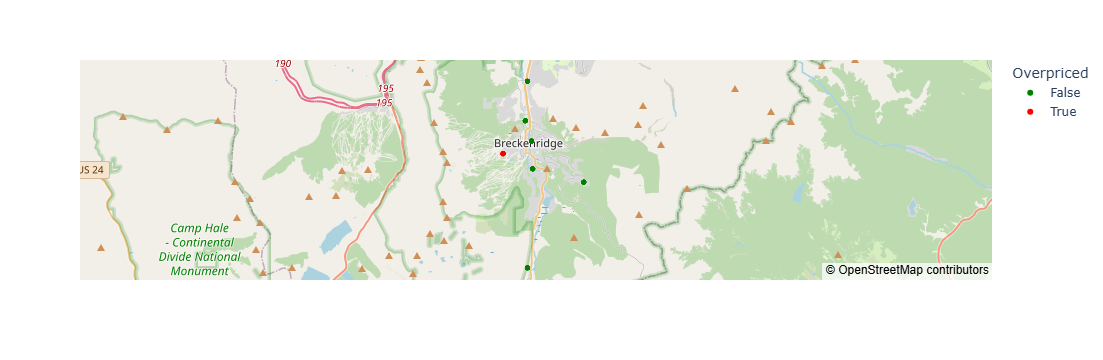

In [29]:

import plotly.express as px
import pandas as pd


# Plotting using Plotly Express
fig = px.scatter_mapbox(df, lat='Latitude', lon='Longitude', hover_name='Address',
                        color='Overpriced', color_discrete_map={False: 'green', True: 'red'},
                        zoom=10, hover_data=['Original_Price', 'Original_Beds', 'Original_Baths', 'Original_Square Footage', 'Cluster'])
fig.update_layout(mapbox_style="open-street-map")
fig.show()


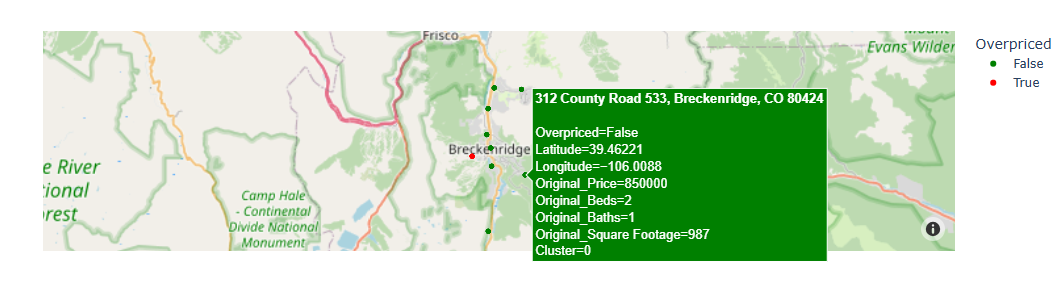

In [30]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\ryan_\\Desktop\\"
Image(filename = PATH + "not_overpriced.png")


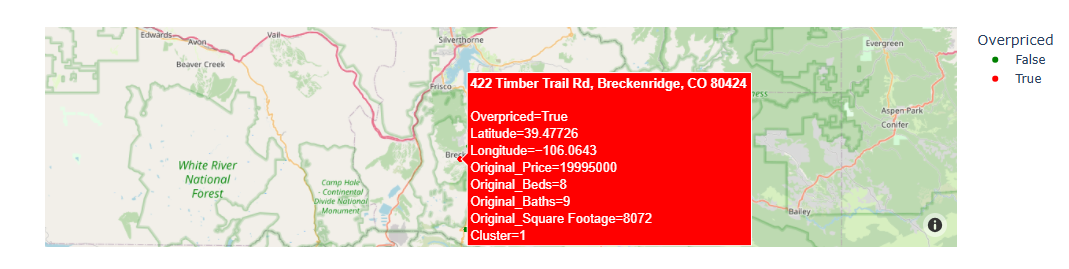

In [31]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\ryan_\\Desktop\\"
Image(filename = PATH + "overpriced.png")


In [ ]:

# END!!! 
